# Group Assignment 1.7: Distribution Fitting

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 7, Friday Oct XX, 2024.*

## Case 1: Wave impacts on a crest wall

**What's the propagated uncertainty? *How large will be the horizontal force?***

In this project, you have chosen to work on the uncertainty of wave periods and wave heights in the Alboran sea to estimate the impacts on a crest wall: a concrete element installed on top of mound breakwater. You have observations from buoys of the significant wave height ($H$) and the peak wave period ($T$) each hour for several years. As you know, $H$ and $T$ are hydrodynamic variables relevant to estimate wave impacts on the structure. The maximum horizontal force (exceeded by 0.1% of incoming waves) can be estimated using the following equation (USACE, 2002).

$$
F_h = \left( A_1 + A_2 \frac{H}{A_c} \right) \rho g C_h L_{0p}
$$

where $A_1=-0.016$ and $A_2=0.025$ are coefficients that depend on the geometry of the structure, $A_c=3m$ is the elevation of the frontal berm of the structure, $\rho$ is the density of water, $g$ is the gravity acceleration, $C_h=2m$ is the crown wall height, and $L_{0p}=\frac{gT^2}{2\pi}$ is the wave length in deep waves. Thus, the previous equation is reduced to

$$
F_h = 255.4 H T^2 -490.4 T^2
$$

**The goal of this project is:**
1. Choose a reasonable distribution function for $H$ and $d$.
2. Fit the chosen distributions to the observations of $H$ and $d$.
3. Assuming $H$ and $d$ are independent, propagate their distributions to obtain the distribution of $S_e$.
4. Analyze the distribution of $S_e$.

## Importing packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats 
from math import ceil, trunc

plt.rcParams.update({'font.size': 14})

## 1. Explore the data

First step in the analysis is exploring the data, visually and through its statistics.

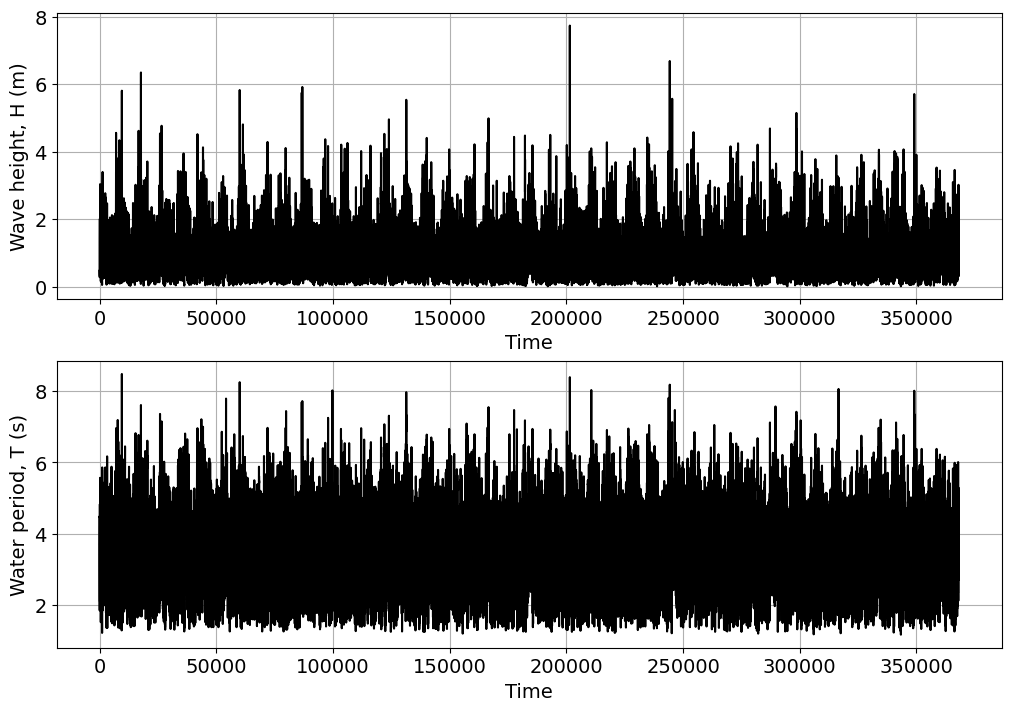

In [15]:
# Import
H, T = np.genfromtxt('data_HT.csv', delimiter=",", unpack = True, skip_header=True)

# plot time series
fig, ax = plt.subplots(2, 1, figsize=(10, 7), layout = 'constrained')
ax[0].plot(H,'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Wave height, H (m)')
ax[0].grid()

ax[1].plot(T,'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Water period, T (s)')
ax[1].grid()

In [16]:
# Statistics for H

print(stats.describe(H))

DescribeResult(nobs=368088, minmax=(0.01, 7.74), mean=0.8741895144639328, variance=0.42290357390467476, skewness=1.6228432185302524, kurtosis=4.214887835366831)


In [17]:
# Statistics for d

print(stats.describe(T))

DescribeResult(nobs=368088, minmax=(1.17, 8.48), mean=3.5363356588641848, variance=0.8783870257212996, skewness=0.587346671055113, kurtosis=0.3230150931433302)


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>   
Describe the data based on the previous statistics:
    <li>Which variable presents a higher variability?</li>
    <li>What does the skewness coefficient means? Which kind of distribution functions should we consider to fit them?</li>
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 1:</b>
    <li>$T$ presents a higher variance but a much higher mean. Then, if we compute the coefficient of variation to standardize that variability, we obtain $CV(H)=0.423/0.874 = 0.484$ and $CV(T)= 0.878/3.526 = 0.249.3$. As expected, $H$ has higher variability than $T$.</li>
    <li>Both $H$ and $T$ has a positive non-zero skewness. Thus, the data presents a right tail and mode < median < mean. An appropriate distribution for $H$ and $T$ would be one which: (1) it is bounded in 0 (no negative values of $H$ or $T$ are physically possible), and (2) has a positive tail. If we consider the distributions that you have been introduced to, Lognormal, Gumbel or Exponential would be a possibility</li>
</div>
</div>

## 2. Empirical distribution functions

Now, we are going to compute and plot the empirical PDF and CDF for each variable. Note that you have the pseudo-code for the empirical CDF in the [reader](https://mude.citg.tudelft.nl/book/probability/empirical.html).

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2:</b>   
Define a function to compute the empirical CDF.
</p>
</div>

In [29]:
def ecdf(var):
    x = np.sort(var) # sort the values from small to large
    n = x.size # determine the number of datapoints\
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

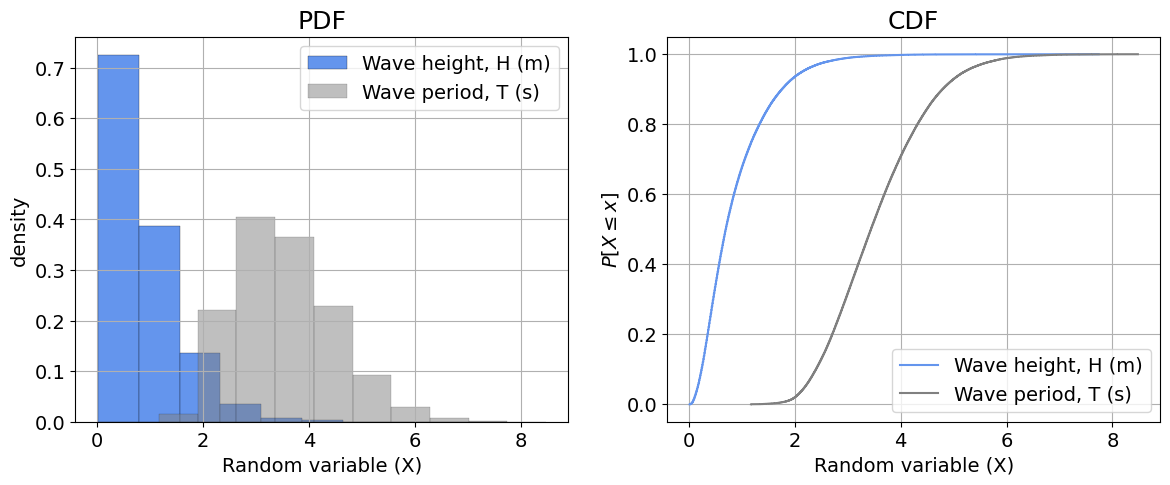

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(H, edgecolor='k', linewidth=0.2, 
             color='cornflowerblue', label='Wave height, H (m)', density = True)
axes[0].set_xlabel('Random variable (X)')
axes[0].set_ylabel('density')
axes[0].hist(T, edgecolor='k', linewidth=0.2, alpha = 0.5, 
             color='grey', label='Wave period, T (s)', density = True)
axes[0].set_title('PDF', fontsize=18)
axes[0].grid()
axes[0].legend()

axes[1].step(ecdf(H)[1], ecdf(H)[0], 
             color='cornflowerblue', label='Wave height, H (m)')
axes[1].set_xlabel('Random variable (X)')
axes[1].set_ylabel('${P[X \leq x]}$')
axes[1].step(ecdf(T)[1], ecdf(T)[0], 
             color='grey', label='Wave period, T (s)')
axes[1].set_title('CDF', fontsize=18)
axes[1].legend()
axes[1].grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>   
Based on the results of Task 1 and the empirical PDF and CDF, select <b>one</b> distribution to fit to each variable (it can be the same).
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 3:</b>
    Based on the results of Task 1, we could consider Lognormal, Gumbel or Exponential for both $H$ and $T$. Based on the shape of the PDF, Exponential can be a good fit for $H$ and Lognormal or Gumbel for $T$. Here, the solution for Gumbel will be shown.</li>
</div>
</div>

## 3. Fitting a distribution

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>   
Fit the selected distributions to the observations using MLE.
</p>
</div>

Hint: Use [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html) built in functions (watch out with the parameters definition!).

In [34]:
params_H = stats.expon.fit(H, floc=0)
params_T = stats.gumbel_r.fit(T)

## 4. Assessing goodness of fit

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>   
Assess the goodness of fit of the selected distribution using:
    <li> One graphical method: QQplot or Logscale. Choose one.</li>
    <li> Kolmogorov-Smirnov test.</li>
</p>
</div>

Hint: You have Kolmogorov-Smirnov test implemented in [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

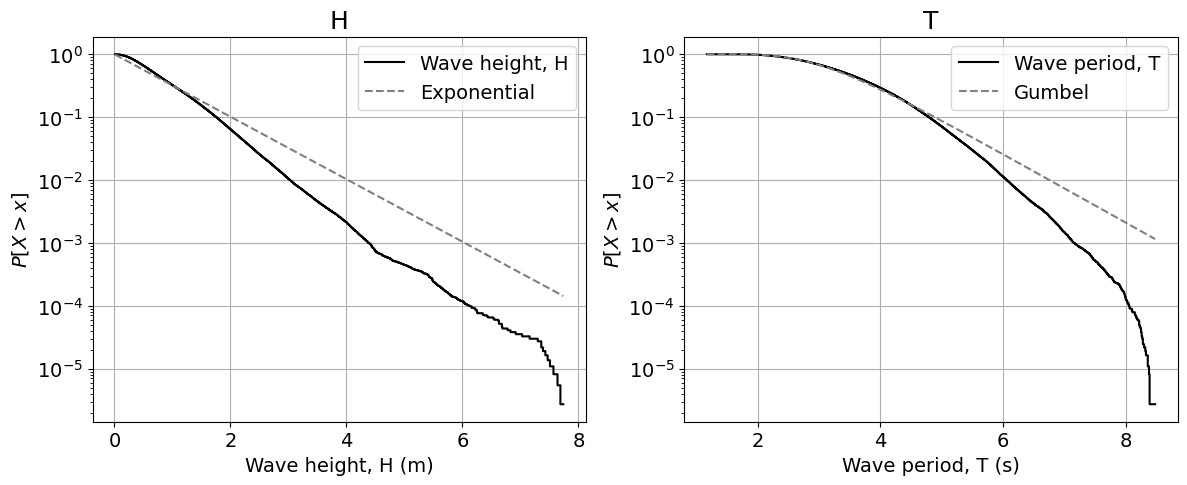

In [35]:
#Graphical method

#Logscale

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].step(ecdf(H)[1], 1-ecdf(H)[0], 
             color='k', label='Wave height, H')
axes[0].plot(ecdf(H)[1], 1-stats.expon.cdf(ecdf(H)[1], *params_H),
             '--', color = 'grey', label='Exponential')
axes[0].set_xlabel('Wave height, H (m)')
axes[0].set_ylabel('${P[X > x]}$')
axes[0].set_title('H', fontsize=18)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid()

axes[1].step(ecdf(T)[1], 1-ecdf(T)[0], 
             color='k', label='Wave period, T')
axes[1].plot(ecdf(T)[1], 1-stats.gumbel_r.cdf(ecdf(T)[1], *params_T),
             '--', color = 'grey', label='Gumbel')
axes[1].set_xlabel('Wave period, T (s)')
axes[1].set_ylabel('${P[X > x]}$')
axes[1].set_title('T', fontsize=18)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid()

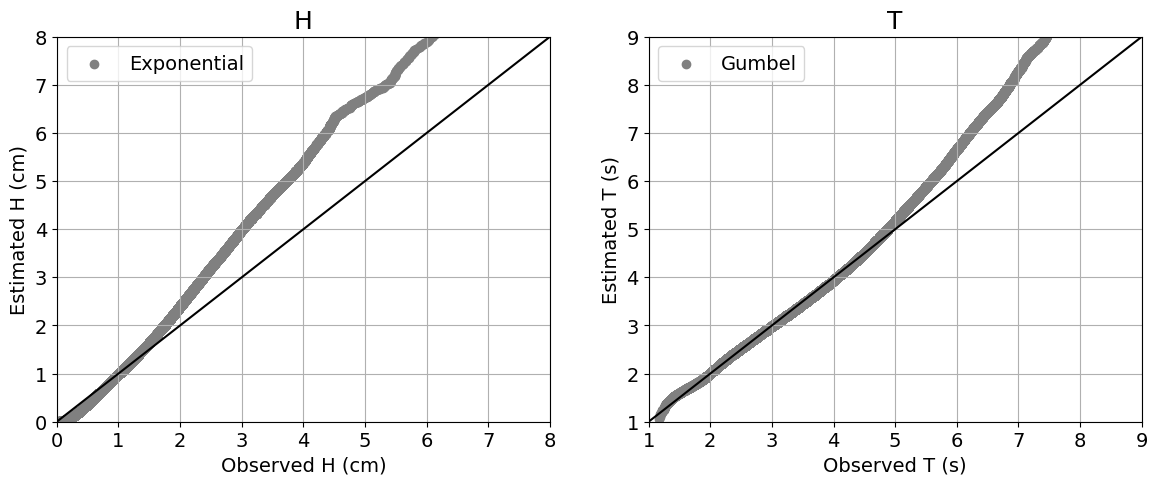

In [36]:
# QQplot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([trunc(min(H)), ceil(max(H))], [trunc(min(H)), ceil(max(H))], 'k')
axes[0].scatter(ecdf(H)[1], stats.expon.ppf(ecdf(H)[0], *params_H), 
             color='grey', label='Exponential')
axes[0].set_xlabel('Observed H (cm)')
axes[0].set_ylabel('Estimated H (cm)')
axes[0].set_title('H', fontsize=18)
axes[0].set_xlim([trunc(min(H)), ceil(max(H))])
axes[0].set_ylim([trunc(min(H)), ceil(max(H))])
axes[0].legend()
axes[0].grid()

axes[1].plot([trunc(min(T)), ceil(max(T))], [trunc(min(T)), ceil(max(T))], 'k')
axes[1].scatter(ecdf(T)[1], stats.gumbel_r.ppf(ecdf(T)[0], *params_T), 
             color='grey', label='Gumbel')
axes[1].set_xlabel('Observed T (s)')
axes[1].set_ylabel('Estimated T (s)')
axes[1].set_title('T', fontsize=18)
axes[1].set_xlim([trunc(min(T)), ceil(max(T))])
axes[1].set_ylim([trunc(min(T)), ceil(max(T))])
axes[1].legend()
axes[1].grid()

In [ ]:
#KStest

#Your answer here

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6:</b>   
Interpret the results of the GOF techniques. How does the selected parametric distribution perform?
</p>
</div>

## 5. Propagating the uncertainty

Using the fitted distributions, we are going to propagate the uncertainty from $H$ and $d$ to $S_e$ assuming that $H$ and $d$ are independent.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 7:</b>   
    
1. Draw 10,000 random samples from the fitted distribution functions for $H$ and $d$.
    
2. Compute $S_e$ for each pair of samples.
    
3. Compute $S_e$ for the observations.
    
4. Plot the PDF and exceedance curve in logscale of $S_e$ computed using both the simulations and the observations.
</p>
</div>

In [ ]:
# Draw random samples


# Compute Se for the random samples and the observations


# plot the PDF and the CDF and compare

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8:</b>   
Interpret the figures above, answering the following questions:
    <li>Are there differences between the two computed distributions for $S_e$?</li>
    <li>What are the advantages and disadvantages of using the simulations?</li>
</p>
</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.